# IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os 
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Definir el estilo de matplotlib
plt.style.use('classic')

# PRETRATAMIENTO DATASET

Los datos de este dataset se obtienen mediante web scraping de la página de REE (Red Eléctrica Española). Se agrupan en subconjuntos anuales que abarcan los periodos desde 2013 hasta 2023, resultando en un total de 11 subdatasets. Estos contienen información mensual sobre la generación eléctrica en GWh de energías renovables y no renovables del sistema eléctrico nacional.
Las energías renovables incluidas son: hidráulica, hidroeólica, eólica, solar fotovoltaica, solar térmica, otras renovables y residuos renovables.

La página de REE impone un límite de 24 meses para la extracción de datos en formato mensual. Debido a esta restricción, se decidió realizar la extracción mensualmente y luego unificar todos los datos en un único dataset. La primera función, 'procesar_archivo', define un diccionario para procesar todos los datasets de manera eficiente.

In [2]:
def procesar_archivo(archivo_entrada:str)->dict:
    """
    Crea un diccionario con las claves fecha, generación de energía GWh para renovables y no renovables con los valores extraídos de un archivo de texto .csv con un formato específico.
    
    Parameters:
    -------------
    achivo_entrada: 
        el nombre del archivo de texto inicial indicando la extensión. 
    Precondition:
    -------------
    delimitador=','  del archivo_origen

    """
    datos_totales = {'fecha':[],'renovable':[],'no renovable':[]}

    with open(archivo_entrada, 'r', encoding='latin-1') as archivo:
        for _ in range(4):
            next(archivo)
        fila5 = next(archivo).strip().split(',')  
        datos_totales['fecha']=fila5[1:]
        
        for _ in range(2):
            fila=next(archivo)
            fila = re.sub(r'"([^"]*),([^"]*)"', r'\1.\2', fila)
            fila=fila.split(',')
            if fila[0]=='Renovable':
                datos_totales['renovable']=[float(valor) for valor in fila[1:]]
            else:
                datos_totales['no renovable']=[float(valor) for valor in fila[1:]]

    return datos_totales

In [3]:
directorio_dataset = 'Dataset 2013-2023'

datos_totales_todos = {}

# Iterar sobre los datasets en el directorio definido
for nombre_archivo in os.listdir(directorio_dataset):
    if nombre_archivo.endswith('.csv') and nombre_archivo.startswith('EVOLUCIÓN DE LA GENERACIÓN RENOVABLE Y NO RENOVABLE'):
        archivo_entrada = os.path.join(directorio_dataset, nombre_archivo)
        datos_archivo = procesar_archivo(archivo_entrada)
        for clave, valor in datos_archivo.items():
            if clave in datos_totales_todos:
                datos_totales_todos[clave].extend(valor)
            else:
                datos_totales_todos[clave] = valor


archivo_salida = 'dataset_unificado.csv'

with open(archivo_salida, 'w', newline='', encoding='latin-1') as archivo:
    # Escribir el encabezado del CSV
    archivo.write("fecha,renovable,no renovable\n")
    
    # Escribir los datos del diccionario en el archivo CSV
    for i in range(len(datos_totales_todos['fecha'])):
        fila = "{},{},{}\n".format(
            datos_totales_todos['fecha'][i],
            datos_totales_todos['renovable'][i],
            datos_totales_todos['no renovable'][i]
        )
        archivo.write(fila)

# CARGAR DATOS

In [4]:
#Cargar los datos del dataset unificado
generacion_energia=pd.read_csv('dataset_unificado.csv') 
#Revisar que la carga ha sido correcta
generacion_energia.head(5)

,fecha,renovable,no renovable
0,01/2013,10308.867015,14488.776856
1,02/2013,10036.405324,12803.546494
2,03/2013,11444.206144,12339.782271
3,04/2013,11269.745363,10592.962961
4,05/2013,9563.030032,11604.536614


In [5]:
generacion_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fecha         132 non-null    object 
 1   renovable     132 non-null    float64
 2   no renovable  132 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.2+ KB


# TRATAMIENTO

In [6]:
# Ajuste de formato de fecha
generacion_energia['fecha']=generacion_energia['fecha'].str.replace('/','-').str.strip()
generacion_energia['fecha']=pd.to_datetime(generacion_energia['fecha'],format='%m-%Y')

# Asociación de la fecha como índice del DataFrame
S_generacion_energia=generacion_energia.set_index('fecha')[['renovable','no renovable']]
S_generacion_energia.head(5)

,renovable,no renovable
fecha,,
2013-01-01,10308.867015,14488.776856
2013-02-01,10036.405324,12803.546494
2013-03-01,11444.206144,12339.782271
2013-04-01,11269.745363,10592.962961
2013-05-01,9563.030032,11604.536614


In [7]:
#Observar como la fecha se transforma el formato de fecha de object a datetime
generacion_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha         132 non-null    datetime64[ns]
 1   renovable     132 non-null    float64       
 2   no renovable  132 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.2 KB


In [8]:
#Crear dos nuevas variables V_ren y V_noren para guardar las series de cada grupo renovables y no renovables.
V_ren=generacion_energia.set_index('fecha')['renovable']
V_noren=generacion_energia.set_index('fecha')['no renovable']

#Asociar la fecha como índice de cada serie.
V_ren=generacion_energia.set_index('fecha')['renovable']
V_noren=generacion_energia.set_index('fecha')['no renovable']

# ANÁLISIS EXPLORATORIO 

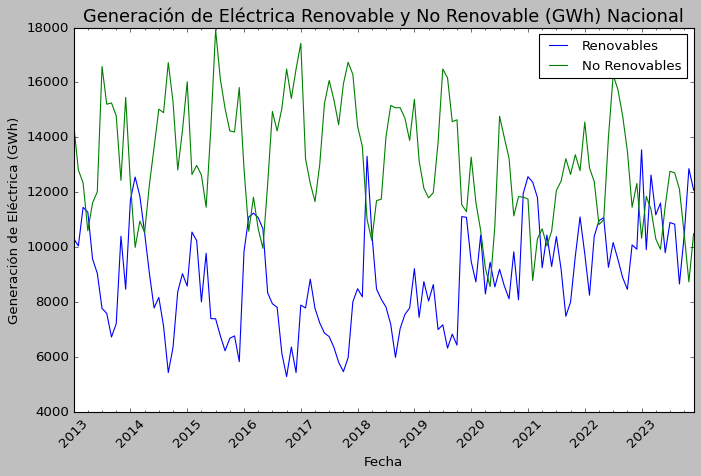

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los datos
S_generacion_energia.plot(ax=ax)
# Título del gráfico y etiquetas de los ejes
ax.set_title('Generación de Eléctrica Renovable y No Renovable (GWh) Nacional', fontsize=16)
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Generación de Eléctrica (GWh)', fontsize=12)

# Leyenda
ax.legend(['Renovables', 'No Renovables'], fontsize=12)

# Rotación de etiquetas del eje x para mejor lectura
plt.xticks(rotation=45)

# Mostrar gráfico
plt.show()


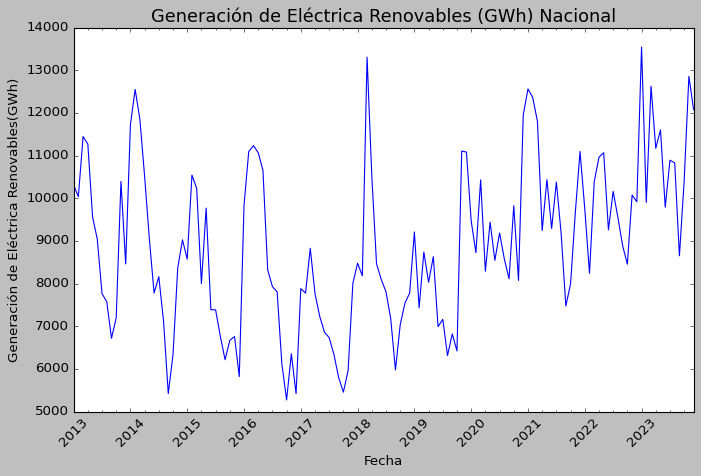

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los datos
V_ren.plot(ax=ax)
# Título del gráfico y etiquetas de los ejes
ax.set_title('Generación de Eléctrica Renovables (GWh) Nacional', fontsize=16)
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Generación de Eléctrica Renovables(GWh)', fontsize=12)

# Rotación de etiquetas del eje x para mejor lectura
plt.xticks(rotation=45)

# Mostrar gráfico
plt.show()

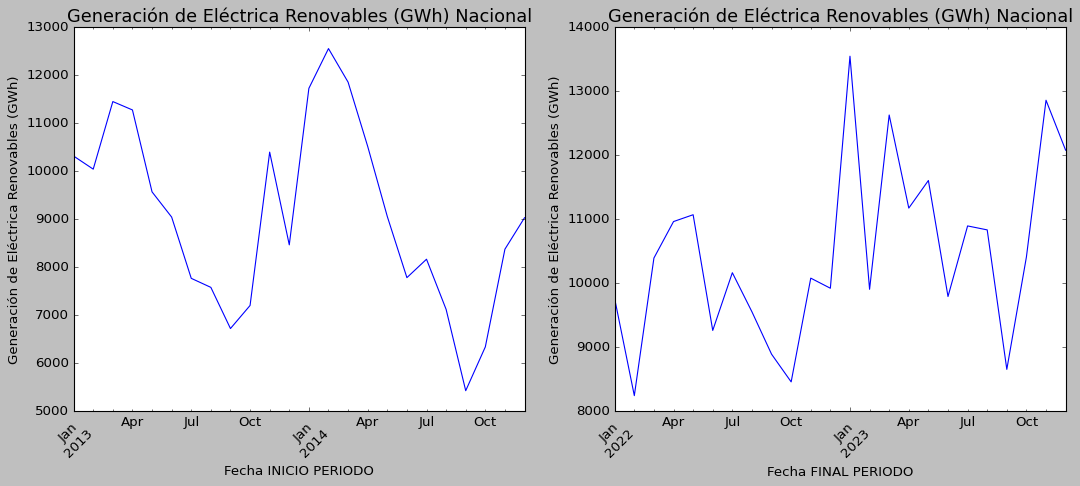

In [11]:
# Crear la figura y los ejes con una disposición de subgráficos de 1 fila y 2 columnas
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Graficar los datos en el primer gráfico
V_ren[:24].plot(ax=ax1)

# Título del primer gráfico y etiquetas de los ejes
ax1.set_title('Generación de Eléctrica Renovables (GWh) Nacional', fontsize=16)
ax1.set_xlabel('Fecha INICIO PERIODO', fontsize=12)
ax1.set_ylabel('Generación de Eléctrica Renovables (GWh)', fontsize=12)

# Rotación de etiquetas del eje x para mejor lectura en el primer gráfico
ax1.tick_params(axis='x', rotation=45)

# Graficar los datos en el segundo gráfico
V_ren[-24:].plot(ax=ax2)

# Título del segundo gráfico y etiquetas de los ejes
ax2.set_title('Generación de Eléctrica Renovables (GWh) Nacional', fontsize=16)
ax2.set_xlabel('Fecha FINAL PERIODO', fontsize=12)
ax2.set_ylabel('Generación de Eléctrica Renovables (GWh)', fontsize=12)

# Rotación de etiquetas del eje x para mejor lectura en el segundo gráfico
ax2.tick_params(axis='x', rotation=45)

# Mostrar gráfico
plt.show()

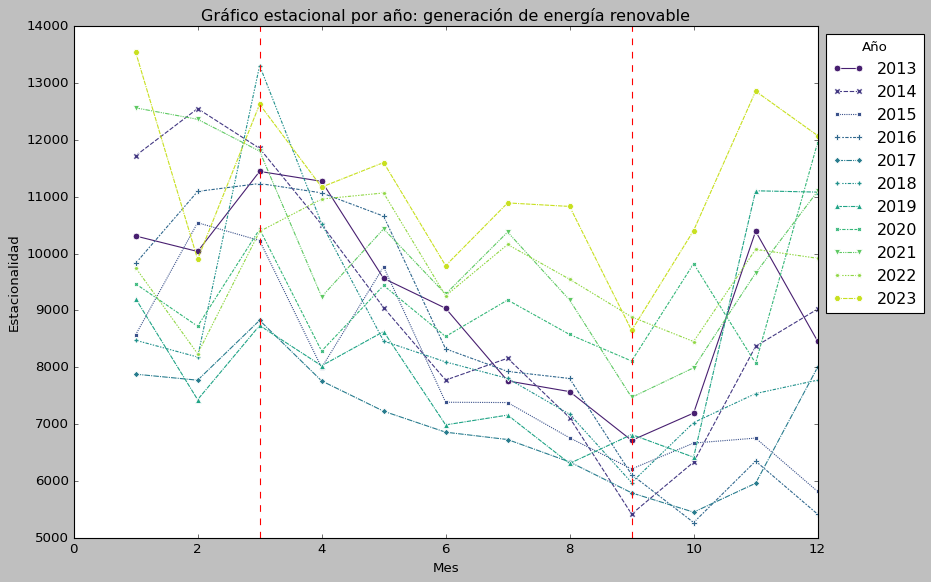

In [12]:
# Convertir el año en una cadena de texto
S_generacion_energia['fecha'] = S_generacion_energia.index.year.astype(str) 

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Graficar los datos
sns.lineplot(x=S_generacion_energia.index.month,
             y=S_generacion_energia.renovable,
             hue=S_generacion_energia['fecha'],
             palette='viridis',
             style=S_generacion_energia['fecha'],
             markers=True)

# Añadir líneas verticales discontinuas
plt.axvline(x=3, color='red', linestyle='--')
plt.axvline(x=9, color='red', linestyle='--')

# Etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Estacionalidad')
plt.title('Gráfico estacional por año: generación de energía renovable')

# Leyenda
plt.legend(title='Año', loc='upper left', bbox_to_anchor=(1, 1))

# Mostrar gráfico
plt.show()


Para observar más detalladamente la estacionalidad, en el gráfico anterior se represntan todos los periodos de manera anual. A simple vista podemos detectar durante el primer trimestre, entorno al mes de marzo, son los meses con mayor generación eléctrica a través de fuentes renovables. Por otro lado, entorno al mes de septiembre se observan descensos en la generación eléctrica por fuentes renovables. Es importante destacar que, a lo largo de los años, se observa cierta variabilidad en los picos y valles, con algunos años donde estos se desplazan un mes arriba o abajo. Sin embargo, a pesar de estas variaciones, se mantiene la estacionalidad en la serie temporal.

Dado que en nuestro dataset no se encuentran valores iguales a 0 o negativos, se procede a aplicar una descomposición estacional multiplicativa en lugar de aditiva, ya que proporciona mejores resultados en este contexto. Con esta se generà un gráfico para mostrar la descomposición estacional de la serie y estudiarla más a fondo. La descomposición consta de cuatro gráficos: datos reales, tendencia, estacionalidad y ruido.

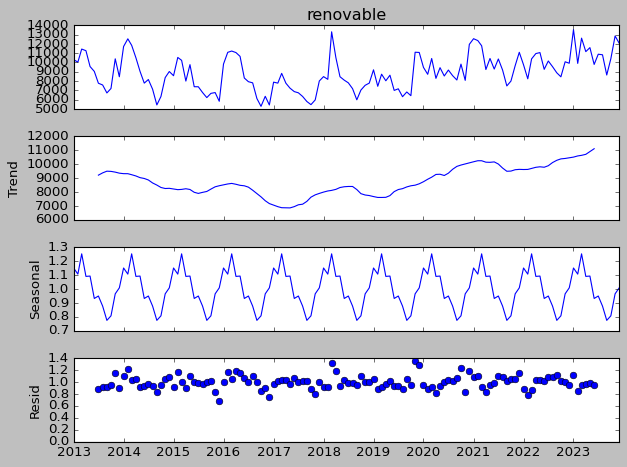

In [13]:
mult_descomposition=seasonal_decompose(V_ren,model='multiplicative',period=12)

seasonal_decompose(V_ren, model='multiplicative', period=12).plot()
plt.tight_layout()
plt.show()

- En el gráfico de la tendencia podemos corroborar nuevamente como en los últimos años existe una tendencia creciente de la generación eléctrica de renovables. 

- En el gráfico de estacionalidad, donde hemos eliminado la tendencia de la serie para resaltar los patrones periódicos, podemos observar nuevamente un pico superior e inferior que representan los meses de marzo y septiembre, respectivamente, con mayor y menor generación eléctrica a través de fuentes renovables. Este patrón recurrente sugiere la influencia de factores estacionales, como las condiciones climáticas y la disponibilidad de recursos naturales, como la luz solar y el viento, que probablemente afectan la producción de energía renovable a lo largo del año.

Para complementar el análisis, se añade un gráfico con la representación superpuesta de los datos originales, la tendencia y la estacionalidad ajustada. La serie estacionalmente ajustada nos permite observar la tendencia subyacente en nuestros datos originales al eliminar el efecto de la estacionalidad. Al aplicar un modelo multiplicativo, dividimos la serie original por el coeficiente de estacionalidad correspondiente a cada período. Esto ayuda a destacar la variación de los datos que no está relacionada con la estacionalidad, lo que puede ser útil para identificar tendencias a largo plazo o anomalías en la serie temporal. 

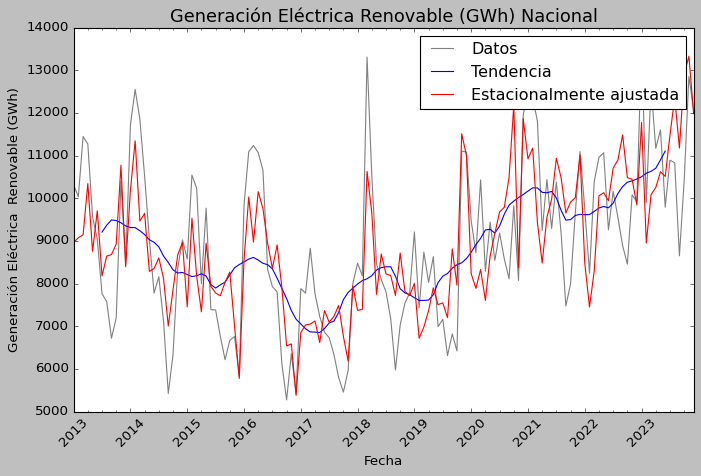

In [14]:
# Calcular la serie ajustada estacionalmente
S_Ajustada_Est = V_ren / mult_descomposition.seasonal

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los datos originales y la tendencia
V_ren.plot(ax=ax, label='Datos', color='gray')
mult_descomposition.trend.plot(ax=ax, label='Tendencia', color='blue')
S_Ajustada_Est.plot(ax=ax, label='Estacionalmente ajustada', color='red')

# Título del gráfico y etiquetas de los ejes
ax.set_title('Generación Eléctrica Renovable (GWh) Nacional', fontsize=16)
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Generación Eléctrica  Renovable (GWh)', fontsize=12)

# Rotación de etiquetas del eje x para mejor lectura
plt.xticks(rotation=45)

# Mostrar la leyenda
plt.legend()

# Mostrar gráfico
plt.show()

Al observar el gráfico anterio se evidencia una tendencia creciente marcada a partir de 2020, pero aún se observan picos muy marcados después de eliminar la estacionalidad. Estos picos podrían indicar variabilidad no explicada en los datos, como posiblemente nuevas políticas energéticas u otros factores externos que no se capturan en la desestacionalización.

# DATOS TRAIN-TEST

In [15]:
train=V_ren[:-12]
test=V_ren[-12:]

# MODELADO

Para aMjustar el modelo de ARIMA manualmente, aplicamos la metodología de Box-Jenkins. Esta serie temporal se considera no estacionaria debido a la presencia de estacionalidad, que se mencionó anteriormente, mostrando un comportamiento repetitivo de las autocorrelaciones cada 12 meses. Por lo tanto, es necesario aplicar una transformación a la serie para convertirla en una serie estacionaria y así poder aplicar ARIMA.

## Representar la serie y los correlogramas

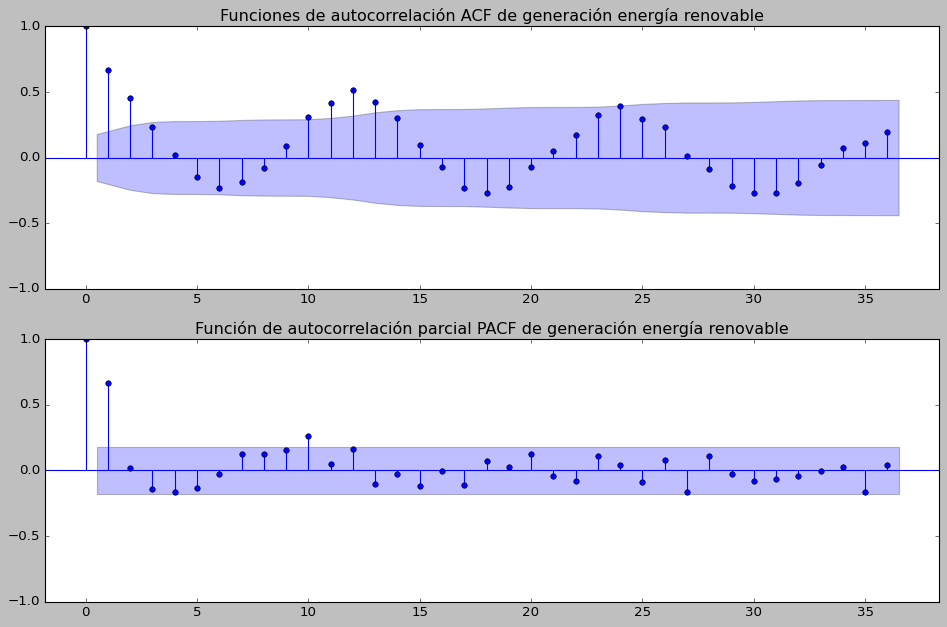

In [16]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,8))

plot_acf(train,lags=36,ax=ax1)
ax1.set_title('Funciones de autocorrelación ACF de generación energía renovable')

plot_pacf(train,lags=36,ax=ax2)
ax2.set_title('Función de autocorrelación parcial PACF de generación energía renovable')

plt.tight_layout()
plt.show()

En el diagrama anterior se observa las funciones de autocorrelación simple (ACF) y autocorrelación parcial (PACF) de la serie temporal. Se ha observado que la autocorrelación más fuerte se encuentra en los retardos múltiplos de 12, lo que confirma, como se había visto anteriormente, la presencia de una estacionalidad clara en los datos. Este patrón de autocorrelación nos indica que la serie exhibe un comportamiento repetitivo cada 12 meses, lo que es consistente con la estacionalidad que habíamos identificado previamente en el análisis exploratorio de datos.

Para poder aplicar el modelo ARIMA, aplicaremos una transformación de diferencias regulares a la serie temporal. Esta transformación implica calcular las diferencias entre periodos consecutivos en la serie, lo que nos permite eliminar la tendencia y la estacionalidad presentes en los datos originales.

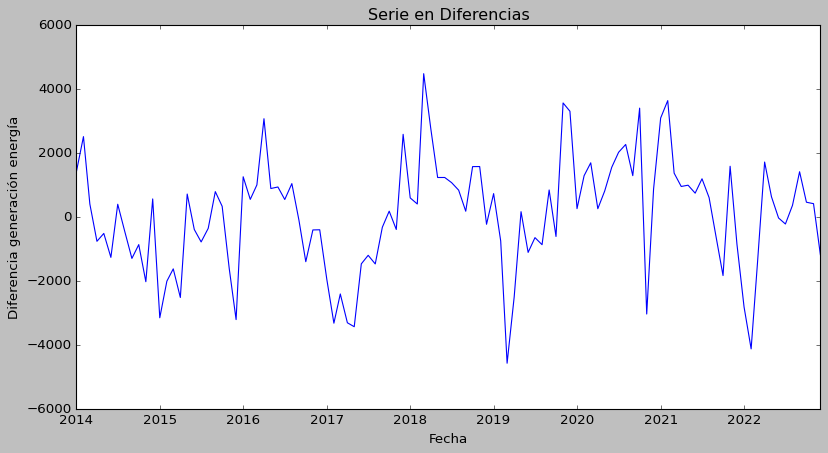

In [17]:
diferencias=train.diff(12)
plt.figure(figsize=(12,6))
plt.plot(diferencias)

plt.title('Serie en Diferencias')
plt.xlabel('Fecha')
plt.ylabel('Diferencia generación energía')
plt.show()


Se observa en el gráfico anterior cómo la nueva serie, obtenida tras aplicar la diferenciación regular a la serie temporal original, presenta valores alrededor de 0 y parece tener una media y varianza constantes. Este resultado indica que la transformación ha logrado eliminar la tendencia y la estacionalidad presentes en los datos originales, convirtiendo la serie en una serie estacionaria.

Ahora, proceder a calcular las autocorrelaciones simples de la serie diferenciada y las autocorrelaciones parciales.

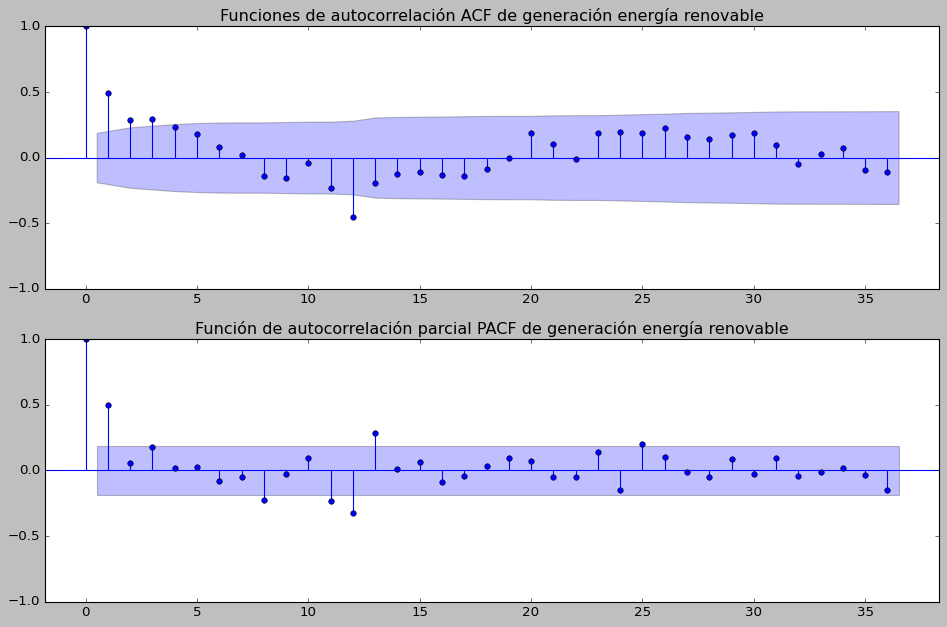

In [18]:
diferencias=diferencias.dropna()

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,8))

plot_acf(diferencias,lags=36,ax=ax1)
ax1.set_title('Funciones de autocorrelación ACF de generación energía renovable')

plot_pacf(diferencias,lags=36,ax=ax2)
ax2.set_title('Función de autocorrelación parcial PACF de generación energía renovable')

plt.tight_layout()
plt.show()

En el gráfico anterios se puede observar cómo el proceso se ha vuelto estacionario después de aplicar la diferenciación regular a la serie temporal. Las autocorrelaciones simples decrecen rápidamente a medida que aumenta el rezago, lo que indica la ausencia de patrones significativos de autocorrelación en los datos diferenciados. Además, observamos correlaciones distintas de cero en las autocorrelaciones parciales, lo que sugiere la presencia de información útil para el ajuste de un modelo ARIMA.

## Modelo ARIMA AUTO 

El enfoque del modelo autoARIMA difiere del método manual al automatizar la selección de los órdenes óptimos del modelo (p,d,q) y (P,D,Q). Esto elimina la necesidad de definir manualmente los parámetros del modelo, lo que simplifica significativamente el proceso y facilita la identificación del mejor modelo para la serie temporal.

$ARIMA(p,d,q)(P,D,Q)s$

El modelo auto-ARIMA optimiza para un determinado information_criterion y devuelve el ARIMA que minimiza el valor. Si no definimos el information_criterion por defecto devuelve 'aic'.
Para definir los modelos del auto-ARIMA es necesario definir los rangos de búsqueda para los términos de autoregresión y media móvil, tanto para la parte no estacional como para la estacional. 
- start_p: el valor inicial de p, el orden del modelo autoregresivo ('AR').
- start_q: el valor inicial de q, el orden del modelo de media móvil ('MA').
- max_p: valor máximo de p inclusive.
- max_q: valor máximo de q inclusive.
- m: el número de periodos en cada temporada o el periodo para diferenciación estacional. 
- start_P: el valor inicial de P, el orden de la parte autoregresiva del modelo estacional.
- d:El orden de la primera diferenciación.
- D:El orden de la diferenciación estacional.
- seasonal: para definir un modelo estacional, por defecto ya es True.

In [19]:
modelo_auto=pm.auto_arima(train,start_p=1,start_q=1,max_p=3,max_q=3,m=12,start_P=0,seasonal=True,d=0,D=1,stepwise=True,
                          trace=True,error_action='warn',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1858.568, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1924.173, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1880.462, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1879.944, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1922.323, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1897.574, Time=0.04 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1860.158, Time=0.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1875.849, Time=0.22 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1863.229, Time=0.25 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1865.667, Time=0.60 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1858.544, Time=0.49 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=1899.101, Time=0.08 sec
 ARIMA(1,0,2)(1,1,1)[12] inte

El auto-ARIMA devuelve el resumen del mejor modelo, es decir, del valor más bajo del criterio de información 'AIC'. Aquí es importante revisar todos los modelos con valores de AIC más bajos para probar distintos modelos y poder aplicar el principio de parsimonia, escogiendo el modelo más simplificado. Además se debe revisar la signficación de los parámetros de los modelos que se escojan y realizar un estudio de los residuos para asegurar que no esten correlacionados.

Si observamos los p-valores asociados a cada parámetro en la columna 'P>|z|, notamos que dos de ellos no son significativos, ya que sus p-valores son superiores a 0.05: ar.L3 y ma.L1. Igualmente se procede a continuar con éste modelo seleccionado para finalizar el análisis.

$ARIMA(3,0,2)(0,1,1)_{12}$


In [20]:
modelo_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -921.712
Date:                              Wed, 29 May 2024   AIC                           1857.423
Time:                                      11:52:53   BIC                           1876.198
Sample:                                  01-01-2013   HQIC                          1865.036
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3983      0.128      3.115      0.002       0.148       0.649
ar.L2          0.7686      0.116      6.647      0.000       0.542       0.995
ar.L3         -0.2186      0.124     -1.763      0.078      -0.462       0.024
ma.L1          0.1487      0.134      1.106      0.269      -0.115       0.412
ma.L2         -0.8277      0.148     -5.576      0.000      -1.119      -0.537
ma.S.L12      -0.6869      0.090     -7.651      0.000      -0.863      -0.511
sigma2      1.424e+06   2.12e+05      6.712      0.000    1.01e+06    1.84e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                19.74
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.54
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+14. Standard errors may be unstable.
"""

En el siguiente gráfico y con el contraste Ljung-Box del summary se pude comprobar que los residuos están incorrelados. Específicamente, el contraste Ljung-Box nos muestra un p-valor por encima de 0.05, en concreto 0.90, lo que nuevamente nos indica la incorrelación de los residuos. Respecto a las gráficas, confirmamos que los coeficientes se encuentran dentro de los límites de confianza y que los residuos muestran una media de 0. Además, observamos en el histograma cómo se ajusta bastante a la distribución normal y presenta un ajuste a una recta.

C:\Users\OT\anaconda3\envs\odin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OT\anaconda3\envs\odin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OT\anaconda3\envs\odin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OT\anaconda3\envs\odin\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


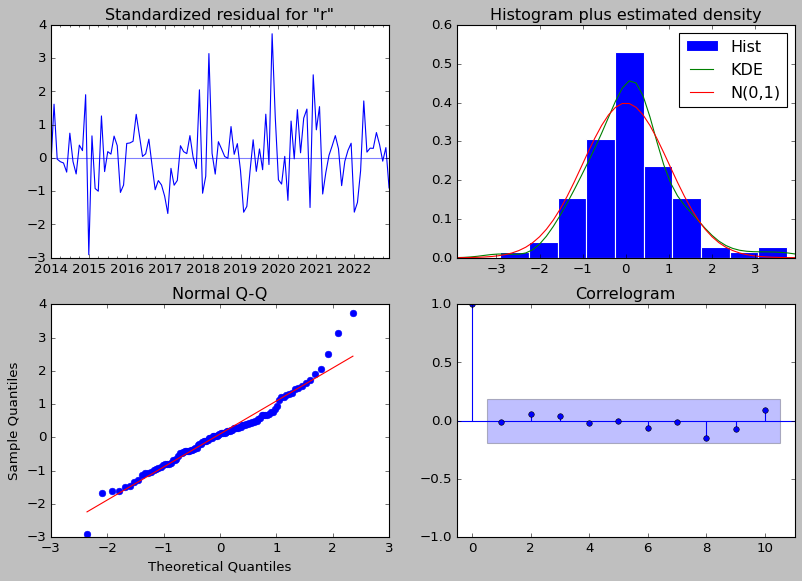

In [21]:
best_arima=sm.tsa.ARIMA(train,order=(3,0,2),seasonal_order=(0,1,1,12))
resultados_a=best_arima.fit()
resultados_a.plot_diagnostics(figsize=(12,8))
plt.show()

# RESULTADOS

In [22]:
predicciones_autoarima=resultados_a.get_forecast(steps=12)
predi_test_a=predicciones_autoarima.predicted_mean

In [23]:
rmse = mean_squared_error(test, predi_test_a,squared=False)
print("Mean Squared Error (RMSE):", rmse)

Mean Squared Error (RMSE): 1752.3689538275696


C:\Users\OT\anaconda3\envs\odin\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


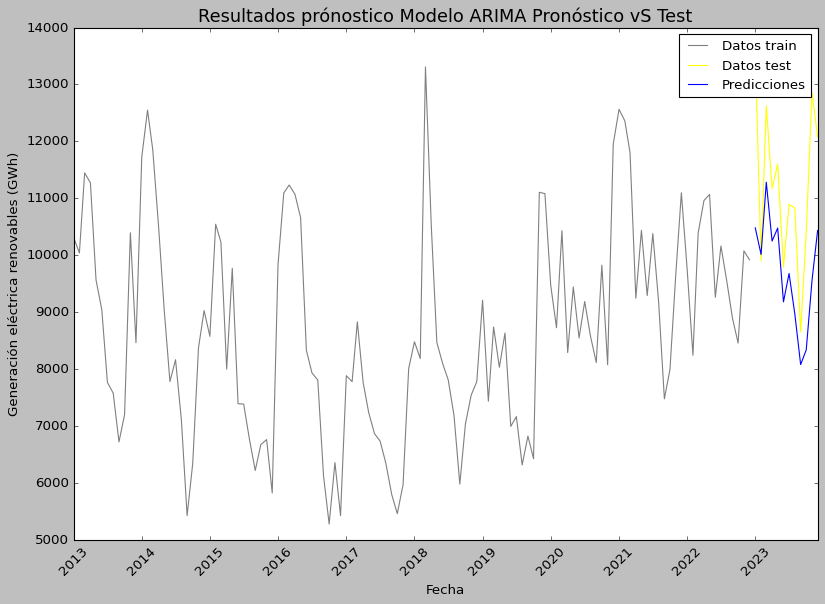

In [24]:
# Crear la figura y los ejes con el tamaño especificado
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos de entrenamiento, prueba y predicciones
ax.plot(train, label='Datos train', color='gray')
ax.plot(test, label='Datos test', color='yellow')
ax.plot(predicciones_autoarima.predicted_mean, label='Predicciones', color='blue')

# Título del gráfico y etiquetas de los ejes
ax.set_title('Resultados prónostico Modelo ARIMA Pronóstico vS Test', fontsize=16)
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Generación eléctrica renovables (GWh)', fontsize=12)

# Leyenda
ax.legend(fontsize=12)

# Rotación de etiquetas del eje x para mejor lectura
plt.xticks(rotation=45)

plt.show()